# This Notebook implements Latent Space Walk

# 1. Import Libraries

In [3]:
import os
import shutil
import sys
sys.path.append('../src/models/')
sys.path.append('../src/utils/')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torchvision import transforms
from torch import autograd
import torch.optim as optim

from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from GNet256_Greyscale import OptGenGreyscale256
from DNet256 import OptDis256

import ignite
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

%matplotlib inline

%load_ext autoreload
%autoreload 2

# 2. Params

In [4]:
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 3. Load Models

In [5]:
netG = torch.load('../models/Greyscale256_NetG_Training')
netD = torch.load('../models/Greyscale256_NetD_Training')

# 3. Prepare Latent Space Walk

In [6]:
def calc_grasc_noise(noise, weight):
    new_noise = noise + (noise.grad*weight*1e-6)
    return new_noise

In [7]:
def show_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [8]:
num_images = 8
grad_steps = 16
skip = 2
nz = 2**4*4*4

In [9]:
optimizer = torch.optim.Adam(netD.parameters(), lr=0.0002)

In [33]:
values = torch.linspace(0, noise.max().item(), num_images) # noise.min().item()
distant_noise = values.repeat_interleave(nz).view(num_images, nz).to(device).requires_grad_()

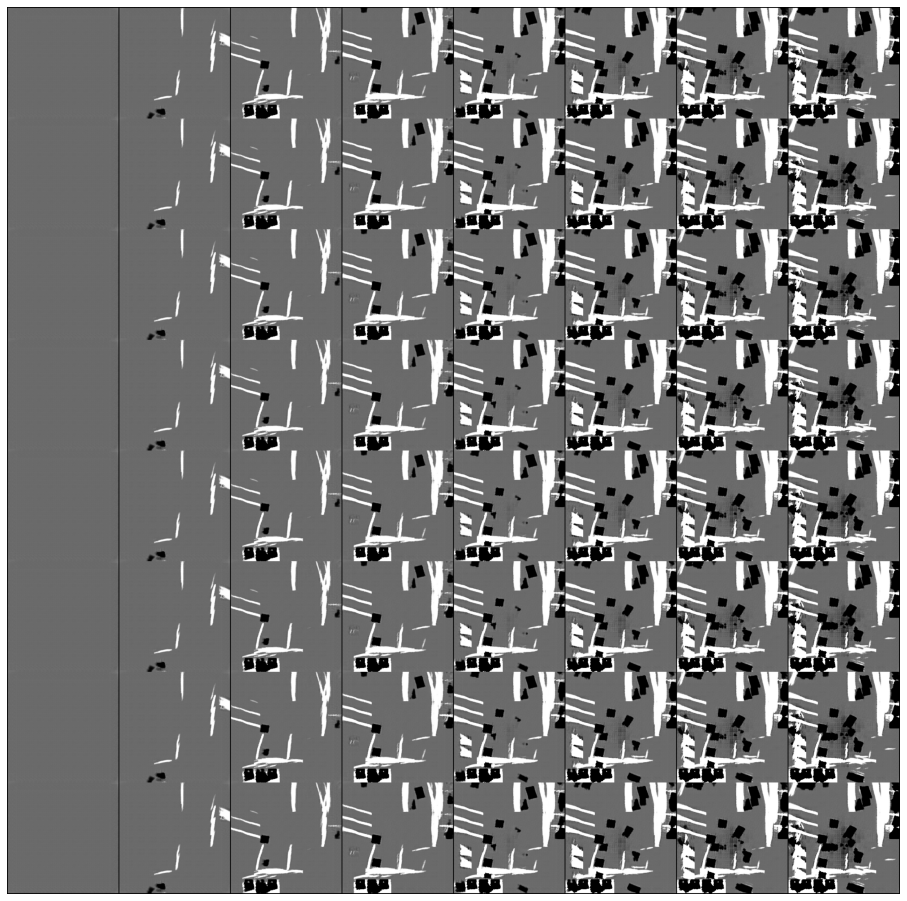

In [34]:
fake_images = []
noise = torch.randn(num_images, nz, device=device).requires_grad_()
for i in range(grad_steps):
    optimizer.zero_grad()
    fake = netG(distant_noise)
    fake_images += [fake]
    score = netD(fake).mean()
    score.backward()
    noise.data = calc_grasc_noise(distant_noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [num_images * 2, grad_steps * 2]
plt.axis('off')
show_images(torch.cat(fake_images[::skip], dim=2), num_images=num_images, nrow=num_images)

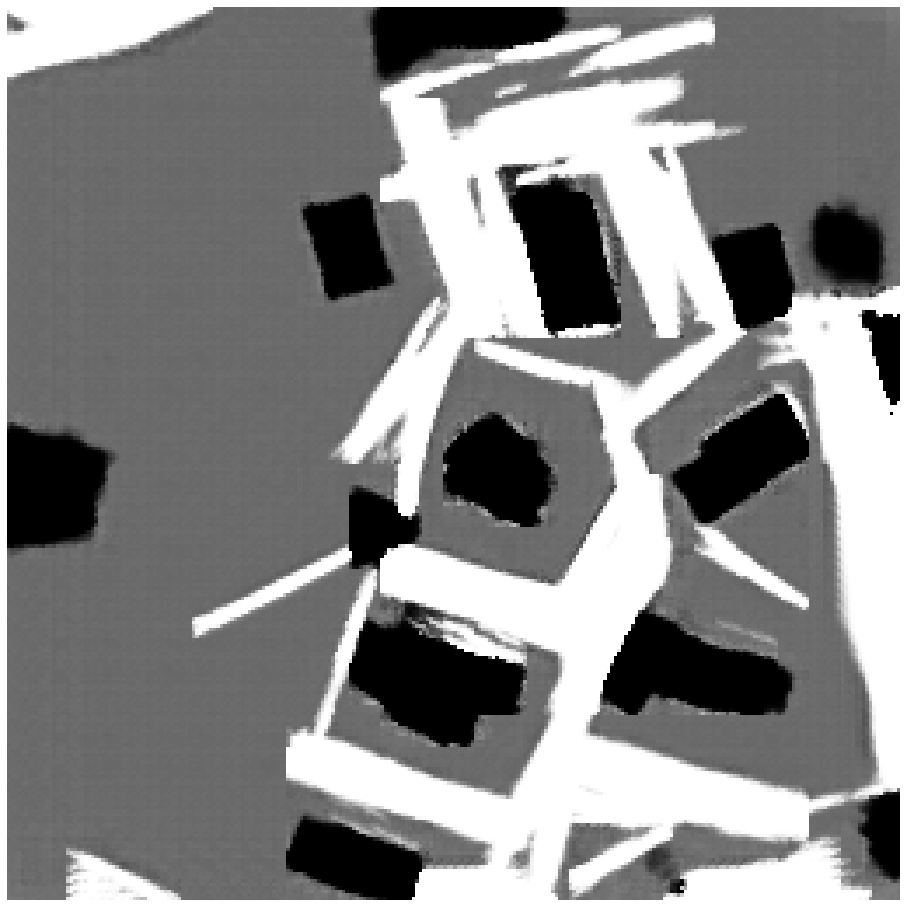

In [32]:
img = fake[2].cpu().detach()

plt.axis('off')
plt.imshow(img.permute(1,2,0), cmap='gray');

In [26]:
img.size()

torch.Size([256, 256])